# Minerador Jornal Estado de São Paulo

Esse notebook tem como objetivo explicar o desenvolvimento do script que será utilizado para minerar a capa do jornal físico _Estado de São Paulo_.

O bloco abaixo apenas importa as bibliotecas utilizadas.

In [5]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
from fake_useragent import UserAgent
import matplotlib.pyplot as plt
import nltk
import re
import requests
import ast
from shapely.geometry import box
import shapely
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import unidecode

É feito o _request_ da página que contém a capa do dia do jornal _O Estado de São Paulo_ . Para isso utilizamos as bibliotecas _selenium_ e _requests_.

Posteriormente utilizamos a biblioteca bs4 para criar o objeto _soup_, que contém o conteúdo HTML da página.

In [28]:
#________Requests Homepage of the newspapper ____________

url = 'http://digital.estadao.com.br/o-estado-de-s-paulo/20180526/'
response = webdriver.Chrome('/usr/bin/chromedriver')
response.get(url)
time.sleep(25)

soup = BeautifulSoup(response.page_source, 'html.parser')

# Close browser
response.close()

#print(soup)

É importante notar que o código obtido não contém o conteúdo das reportagens. Em vez disso, ele contém vários blocos de _layout_ que possuem cada um: 
* _article-id_ : número único de identificação de cada reportagem
* _page-number_: número de identificaçãoda página
* _left_; _top_; _width_; _height_ : 'coordenadas' de _layout_ HTML 

No código abaixo fazemos a filtragem desses blocos e salvamos em uma lista chamada _dadosArtigosPag1_. Fazemos também uma lista contendo todos os id pertencentes à capa do jornal (idArtigosPag1). 

In [29]:
dadosArtigos = soup.find_all('div', class_='block' )

dadosArtigosPag1 = []
idArtigosPag1 = []
for artigo in dadosArtigos:
    try:
        #Only newspaper cover
        if artigo.attrs['page-number'] == '1':
            dadosArtigosPag1.append(artigo)
            try:
                idArtigosPag1.append(artigo.attrs['article-id'])
            except:
                pass
            #print (artigo)
    except:
        pass



Como existem mais de um bloco para uma mesma *id*, se faz necessário o uso da função _set_ para criar uma lista de _ids_ únicas.

In [30]:
#only unique ids
idArtigosPag1 = set(idArtigosPag1)

A partir daqui, toda informação raspada e gerada estará associada a um artigo. Como boa prática de programação, organizaremos essas informações instanciando objetos da classe *artigo*. Está classe está definida abaixo, juntamente com a classe *coordenada*, da qual é dependente.

In [31]:
class coordenadas:
    def __init__(self, left, top, w, h):
        self.xmin = float(left)
        self.ymin = float(top)
        self.xmax = float(left) + float(w)
        self.ymax = float(top) + float(h)
    def printBlock(self):
        print (self.xmin)
        print (self.ymin)
        print (self.xmax)
        print (self.ymax)

## Instruções para uso da classe *artigo*

### Sintaxe
Para instanciar um objeto, utilize a seguinte sintaxe:

* instanciaArtigo = artigo(dadosArtigosPag1, '281530816692202')

onde: *dadosArtigosPag1* são os vários blocos de layout supra-definidos.
          *281530816692202* é o id de um artigo

### Atributos
#### De interesse para o programador final (usado para extrair informação do artigo)
* .id ->
* .dadosArtigos -> 
* .blocos ->
* .areaReportagem ->
* .url ->

#### De interesse do programador back-end (usado para programar os métodos)
* .listaCoordenadas ->
* .rects ->
* .union ->


### Métodos
* Todos os métodos são programações back-end e não devem ser usados pelo programador final. Exceto o método **.plotAreaUnion()** que pode ser usado para vizualizar a área impressa de uma reportagem.


In [111]:
#________Class artigo:  ____________

class artigo:
    
    def __init__(self, dadosArtigos, idArtigo):
        self.id = idArtigo
        self.dadosArtigos = dadosArtigos
        self.blocos = self.getBlocos()
        self.listaCoordenadas = self.getCoordenadas()
        self.rects = self.getListaBox()
        union = self.getUnionArea()
        self.areaReportagem = union.area/100
        self.url = self.getUrl()
        self.conteudo = self.getConteudo()
    
    # Esse metodo retorna os blocos associados ao id do artigo
    def getBlocos (self):
        blocos = []
        for artigo in self.dadosArtigos:
            try:
                if artigo.attrs['article-id'] == self.id :
                    blocos.append(artigo)
            except:
                pass
        return blocos
    
    def getCoordenadas (self):
        listaBlock = []
        for bloco in self.blocos:
            temp = bloco.attrs['style']
            temp = re.split('[, \-!?:;%]+', temp)
            listaBlock.append(coordenadas(temp[5], temp[7], temp[9], temp[11]))
        return listaBlock
    
    def getListaBox (self):
        rects = []
        for i in range (0, len(self.listaCoordenadas)):
            #print(i)
            rects.append (box( self.listaCoordenadas[i].xmin,  self.listaCoordenadas[i].ymin,  self.listaCoordenadas[i].xmax,  self.listaCoordenadas[i].ymax))
            #print (list(rects[i].exterior.coords))
        return rects
    
    def getUnionArea (self):
        a = self.rects[0]
        for rect in self.rects:
            a = a.union(rect)
        union = a
        return union
    
    def plotAreaUnion (self):
        # plot the rectangles before and after merging 
        patches  = PatchCollection([Polygon(a.exterior) for a in self.rects], facecolor='red', linewidth=.5, alpha=.5)
        intersect_patch =  PatchCollection([Polygon(self.getUnionArea().exterior)], facecolor='red', linewidth=.5, alpha=.5)
        # make figure
        fig, ax = plt.subplots(1,2, subplot_kw=dict(aspect='equal'))
        ax[0].invert_yaxis()
        ax[0].add_collection(patches, autolim=True)
        ax[0].autoscale_view()
        ax[0].set_title('Blocos Separados')
        ax[1].add_collection(intersect_patch, autolim=True)
        ax[1].set_title('Blocos Unidos (Area do Artigo)')
        ax[1].set_xlim(ax[0].get_xlim())
        ax[1].set_ylim(ax[0].get_ylim())
        plt.show()
        
    def getUrl(self):
        preUrl = 'https://svc.pressreader.com/se2skyservices/articles/GetItems/?accessToken=qqFXsNdefpOrPBWQoOnLnKzQfV0keocabvJnYTnxhPkAsy4mE2ZRfqE8hHT7kVL2_HhSJsE80g5zb9AXtzfVZg!!&articles='
        finalUrl = '&comment=LatestByAll&options=1&viewType=text'
        urlReportagen = preUrl + self.id +  finalUrl
        return urlReportagen
    
    
    def getConteudo(self):
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36 OPR/52.0.2871.99'}
        response = requests.get(self.url, headers=headers)
        conteudo = json.loads(response.text)
        return conteudo

Definida as classes *artigo* e suas dependentes, agora temos que raspar os dados da capa. Para isso, basta ...

____________________________________________________________________________________________________________________________

 <h1><center>Comentado FIM</center></h1>
_____________________________________________________________________________________________________________________________


# Exemplos de uso:

### Instanciação do artigo exemplo: 

In [112]:
artigoExemplo = artigo(dadosArtigosPag1, '281530816692202')

### Print da área da reportagem:

In [113]:
print (artigoExemplo.areaReportagem)

42.573691


### Imprenssão da área da reportagem:

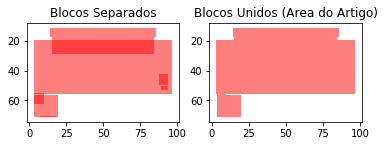

In [114]:
artigoExemplo.plotAreaUnion()

### Print da url do artigo:

In [115]:
print (artigoExemplo.url)

https://svc.pressreader.com/se2skyservices/articles/GetItems/?accessToken=qqFXsNdefpOrPBWQoOnLnKzQfV0keocabvJnYTnxhPkAsy4mE2ZRfqE8hHT7kVL2_HhSJsE80g5zb9AXtzfVZg!!&articles=281530816692202&comment=LatestByAll&options=1&viewType=text


### Print do conteúdo do artigo:

* É importante notar que esse atributo é provavelmente o mais importante da classe. Nele temos varias informações, como: Título, subtítulo, data, rate, texto, imagem, rank etc.
* O conteúdo do atributo está em formato Json e pode ser explorado utilizando a sintaxe padrão da estrutura dicionário do Python.

In [118]:
artigoExemplo.conteudo

{'Articles': [{'Abstract': None,
   'AccessBookmarkId': None,
   'AnalyticProfiles': [],
   'Annotation': None,
   'ArticleId': '281530816692202',
   'ArticleType': 0,
   'Blocks': [{'Text': 'Uma sequên\xadcia de quei\xadxas ig\xadno\xadra\xaddas pe\xadlo go\xadver\xadno, um acor\xaddo cos\xadtu\xadra\xaddo de última ho\xadra e a ra\xaddi\xadca\xadli\xadza\xadção chan\xadta\xadgis\xadta de uma ca\xadte\xadgo\xadria pa\xadra\xadram o Bra\xadsil. Des\xadde ou\xadtu\xadbro de 2017, o se\xadtor de trans\xadpor\xadtes tem cha\xadma\xaddo a aten\xadção do Pla\xadnal\xadto, mas o go\xadver\xadno dei\xadxou o te\xadma de la\xaddo. Quan\xaddo a ne\xadgo\xadci\xada\xadção foi ini\xadci\xada\xadda, o mo\xadvi\xadmen\xadto já era mai\xador que os lí\xadde\xadres. As\xadsim, mes\xadmo de\xadpois de o go\xadver\xadno ce\xadder aos gre\xadvis\xadtas, vá\xadri\xados gru\xadpos in\xadsis\xadti\xadram em blo\xadque\xadar es\xadtra\xaddas e tor\xadna\xadram o País re\xadfém de seus plei\xadtos. No Pla\xa

Vale resaltar que embora o encoding acima apresente erro, ao *printar* um dado específico o mesmo não é um problema. Ex:

*Print* do primeiro parágrafo do artigo inicial: 

In [119]:
dados = response.json()

print(artigoExemplo.conteudo['Articles'][0]['Blocks'][0]['Text'])

Uma sequên­cia de quei­xas ig­no­ra­das pe­lo go­ver­no, um acor­do cos­tu­ra­do de última ho­ra e a ra­di­ca­li­za­ção chan­ta­gis­ta de uma ca­te­go­ria pa­ra­ram o Bra­sil. Des­de ou­tu­bro de 2017, o se­tor de trans­por­tes tem cha­ma­do a aten­ção do Pla­nal­to, mas o go­ver­no dei­xou o te­ma de la­do. Quan­do a ne­go­ci­a­ção foi ini­ci­a­da, o mo­vi­men­to já era mai­or que os lí­de­res. As­sim, mes­mo de­pois de o go­ver­no ce­der aos gre­vis­tas, vá­ri­os gru­pos in­sis­ti­ram em blo­que­ar es­tra­das e tor­na­ram o País re­fém de seus plei­tos. No Pla­nal­to, a ava­li­a­ção é de que a Agên­cia Bra­si­lei­ra de Inteligência (Abin) fa­lhou ao não pre­ver o al­can­ce do mo­vi­men­to.


____________________________________________________________________________________________________________________________

 <h1><center>Ainda em construção:</center></h1>
_____________________________________________________________________________________________________________________________

## Exportação

Para finalizar é necessário a exportação dos dados para o Banco de Dados. Para isso precisaremos...

In [120]:
test = pd.read_csv('https://docs.google.com/spreadsheet/ccc?key=1Rf2ZGMcmbei0JR4OPcHrMsDNQIusnWsfMtqgGQiQ6qI&output=csv',
                   # Set first column as rownames in data frame
                   index_col=0,
                  )
test.head(5)  # Same result as @TomAugspurger

,Data,Horário,Nome do veículo da notícia,Tipo do veículo da notícia,Manchete,Sub-título,Texto,Tema,Assunto (Tags),Relacionamento,...,Personagem Principal,Foto,Tamanho do tempo da notícia,Tamanho (Proporção),Jornalista reponsável pela notícia,Valência 1 (Primeiro Avaliador),Valência 1 (Segundo Avaliador),Valência 2 (Primeiro Avaliador),Valência 2 (Segundo Avaliador),Observações
Nome,,,,,,,,,,,,,,,,,,,,,


## Anotações que podem ser interessantes:

### Links interessantes

https://svc.pressreader.com/se2skyservices/pagesMetadata/?accessToken=nGZdrggOA-3icLrzAVChepbp4pDpZWemMLpA61PK4Rm_w2Y5OwbqS5zgElyc8uHdr31BN_ULTJiJ4vhLGGgqXw!!&issue=20252018052600000000001001&pageNumbers=1%2C2%2C3

